In [1]:
import torch
import numpy as np
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    PreTrainedTokenizerBase,
    PreTrainedModel,
)
import json


device = "mps"

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load(model_path) -> tuple[PreTrainedModel, PreTrainedTokenizerBase]:
    model = AutoModelForCausalLM.from_pretrained(model_path).to(device)

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    if model.config.pad_token_id is None:
        model.config.pad_token_id = model.config.eos_token_id

    return model, tokenizer

In [ ]:
gpt2_model_path = "/Users/aszab/repos/models/gpt2"
model, tokenizer = load(gpt2_model_path)

In [6]:
llama3_model_path = "/Users/aszab/repos/models/Llama-3.2-1B"
model, tokenizer = load(llama3_model_path)

In [7]:
inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)

outputs = model(
    **inputs,
    # pad_token_id=model.config.pad_token_id
    labels=inputs["input_ids"],
)
past_key_values = outputs.past_key_values
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

---

## TMP -- experimental

In [91]:
inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)

outputs = model(
    **inputs,
    # pad_token_id=model.config.pad_token_id
    labels=inputs["input_ids"],
)
past_key_values = outputs.past_key_values
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

In [93]:
inputs = tokenizer("really", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(
        inputs["input_ids"][:, :],
        # pad_token_id=model.config.pad_token_id
        past_key_values=past_key_values,
        use_cache=True,
    )

In [94]:
tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])

' friendly'

---

## Attention forward pass re-implementation for Llama-3.2

This implementation caches keys before the positional encodings have been applied to the projection outputs. Hence, it is possible to dynamically change the positions of tokens however needed. *Shout out to RoPE encodings!*

In [3]:
import math
from typing import Optional, Tuple, Literal

from torch import nn
import torch.utils.checkpoint

from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    rotate_half,
    repeat_kv,
)
import types

from transformers.cache_utils import Cache

__all__ = ["enable_llama_pos_shift_attention"]


def apply_rotary_pos_emb_x(x, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed


def llama_original_attention_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    past_key_value: Optional[Cache] = None,
    output_attentions: bool = False,
    position_embeddings: Optional[
        Tuple[torch.Tensor, torch.Tensor]
    ] = None,  # will become mandatory in v4.46
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    bsz, q_len, _ = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    # use -1 to infer num_heads and num_key_value_heads as they may vary if tensor parallel is used
    query_states = query_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)

    # Figure out the length of the key value sequence given current and cached key value states
    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None and len(past_key_value) > self.layer_idx:
        kv_seq_len += past_key_value[self.layer_idx][0].shape[-2]

    # If we have a cache, we can use it to avoid recomputing the key value states.
    # NOTE: Keys are stored without positional encodings added.
    if past_key_value is not None:
        key_states, value_states = past_key_value.update(
            key_states,
            value_states,
            self.layer_idx,
        )

    # Recompute rotary_emb for the entire sequence. In theory this could be done once when the model is instantiated.
    cos, sin = self.rotary_emb(
        value_states,
        position_ids=torch.arange(kv_seq_len, device=value_states.device).unsqueeze(0),
    )

    # Compute keys and queries with rotary embeddings separately given they may have different lengths due to caching.
    key_states = apply_rotary_pos_emb_x(key_states, cos, sin)
    query_states = apply_rotary_pos_emb_x(
        query_states, cos[:, -q_len:, :], sin[:, -q_len:, :]
    )

    # Continue with the original transformers Llama implementation
    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)
    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(
        self.head_dim
    )

    if attention_mask is not None:  # no matter the length, we just slice it
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(
        query_states.dtype
    )
    attn_weights = nn.functional.dropout(
        attn_weights, p=self.attention_dropout, training=self.training
    )
    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.reshape(bsz, q_len, -1)

    attn_output = self.o_proj(attn_output)

    if not output_attentions:
        attn_weights = None

    return attn_output, attn_weights, past_key_value


# Replace all default llama attention modules with the new implementation above.
def enable_llama_pos_shift_attention(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            enable_llama_pos_shift_attention(
                module,
            )

        if isinstance(module, LlamaAttention):
            model._modules[name].forward = types.MethodType(
                llama_original_attention_forward, model._modules[name]
            )

In [15]:
enable_llama_pos_shift_attention(model)

NameError: name 'model' is not defined

---

## Load data used for perplexity evaluation

In [4]:
def load_data():
    data_wikitext = load_dataset(
        "wikitext", "wikitext-2-raw-v1", split="test", cache_dir="~/repos/datasets"
    )
    data_wikitext = "\n\n".join(
        list(filter(lambda x: len(x) > 0, data_wikitext["text"]))
    )

    return data_wikitext

In [7]:
data_wikitext = load_data()

encodings = tokenizer(data_wikitext, return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


## Verify I implemented the sink attention correctly

In [8]:
reference_model, _ = load(llama3_model_path)

### Qualitative evaluation on a sample text

In [9]:
def sample_evaluate_sink_attn(
    chosen_model: PreTrainedModel, prompt: str, num_tokens: int = 10
) -> list[str]:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generations = []

    outputs = chosen_model(
        **inputs,
    )
    past_key_values = outputs.past_key_values
    generations.append(
        tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])
    )

    for _ in range(num_tokens):
        pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

        outputs = chosen_model(
            pred_token_idx,
            labels=None,
            past_key_values=past_key_values,
        )
        past_key_values = outputs.past_key_values

        generations.append(
            tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])
        )
    return generations

In [10]:
prompt = "Hello, my dog is cute and"
num_tokens = 17
generation = sample_evaluate_sink_attn(model, prompt, num_tokens=num_tokens)
reference_generation = sample_evaluate_sink_attn(
    reference_model, prompt, num_tokens=num_tokens
)

print(prompt + "...\n")
print("modified model | reference model")
for gen, ref_gen in zip(generation, reference_generation):
    print(gen + (len("modified model") - len(gen)) * " ", ref_gen, sep=" |")

We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


Hello, my dog is cute and...

modified model | reference model
 playful       | playful
,              |,
 but           | but
 he            | he
 is            | is
 very          | very
 aggressive    | aggressive
 and           | and
 he            | he
 bites         | bites
 me            | me
 when          | when
 I             | I
 try           | try
 to            | to
 pet           | pet
 him           | him
.              |.


### Test logits given a longer sequence

In [11]:
print(tokenizer.decode(encodings.input_ids[:, :512][0]))

<|begin_of_text|> = Robert Boulter = 


 Robert Boulter is an English film, television and theatre actor. He had a guest @-@ starring role on the television series The Bill in 2000. This was followed by a starring role in the play Herons written by Simon Stephens, which was performed in 2001 at the Royal Court Theatre. He had a guest role in the television series Judge John Deed in 2002. In 2004 Boulter landed a role as " Craig " in the episode " Teddy's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi. He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur, which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London. He was directed by John Tiffany and starred alongside Ben Whishaw, Shane Zaza, Harry Kent, Fraser Ayres, Sophie Stanton and Dominic Hall. 


 In 2006, Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill. He appeared on a 20

In [12]:
with torch.no_grad():
    outputs = model(
        encodings.input_ids[:, :512].to(device),
        labels=encodings.input_ids[:, :512].to(device),
    )
    reference_outputs = reference_model(
        encodings.input_ids[:, :512].to(device),
        labels=encodings.input_ids[:, :512].to(device),
    )

In [13]:
torch.equal(outputs.logits, reference_outputs.logits)

True

### Test caching across generations

In [14]:
past_key_values = None
reference_past_key_values = None

for idx in tqdm(range(256)):
    tokens = encodings.input_ids[:, idx : idx + 1].to(device)
    with torch.no_grad():
        outputs = model(
            tokens,
            past_key_values=past_key_values,
        )
        past_key_values = outputs.past_key_values

        reference_outputs = reference_model(
            tokens,
            past_key_values=reference_past_key_values,
        )
        reference_past_key_values = reference_outputs.past_key_values

    assert torch.equal(outputs.logits, reference_outputs.logits)

    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

100%|██████████| 256/256 [00:21<00:00, 12.03it/s]


### Dense Attention, Window Attention, Sliding Window with Recomputation, Sink Attention

- For dense attention set `kv_cache_size=-1`, `sink_attn_tks=0`.
- For window attention set `kv_cache_size` to desired max cache length value and `sink_attn_tks=0`.
- For sliding window with recomputation set `recompute=True` and set `kv_cache_size` to desired max window value.
- For sink attention set both `kv_cache_size` and `sink_attn_tks` to desired values.

`chunk_len` specifies the maximum length of an evaluation sequence. E.g. `chunk_len=5` computes over `A B C D E` F G H I J K

`num_passes` specifies the max number of PPL computations over a sequence of length `chunk_len`. 

`shift_len` specifies the number of tokens the main sequence is shifted by to compute perplexity for the next pass.

E.g. `num_passes=3, chunk_len=5, shift_len=2` computes over:
- `A B C D E` F G H I J K ...
- A B `C D E F G` H I J K ...
- A B C D `E F G H I` J K ...


**TODO:**

Two experiments:
1. Analyse how the PPL/NLL and generation time and memory usage curves vary across a single long generation
    - ~120k for LLama-3-1B
    - ~20k for GPT2
2. Perform a more quantitative analysis by computing stuff with more passes (10/20?)



In [16]:
experiment1a_config = {
    "num_passes": 1,
    "chunk_len": 2048,
    "shift_len": 50,  # unused with 1 pass
    "model": "/Users/aszab/repos/models/gpt2",
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,  # means infinite cache
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

experiment1b_config = {
    "num_passes": 1,
    "chunk_len": 2048,
    "shift_len": 50,  # unused with 1 pass
    "model": "/Users/aszab/repos/models/Llama-3.2-1B",
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}


experiment1c_config = {
    "num_passes": 1,
    "chunk_len": 150_000,
    "shift_len": 50,  # unused with 1 pass
    "model": "/Users/aszab/repos/models/Llama-3.2-1B",
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

experiment2_config = {
    "num_passes": 10,
    "chunk_len": 1024,
    "shift_len": 50,
    "model": "/Users/aszab/repos/models/Llama-3.2-1B",
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

In [17]:
# Cache evicion policy for sink attention. If sink_attn_tks is set to 0, the policy becomes lru (least recently used).
def cache_eviction_sink(kv_cache, kv_cache_size: int, sink_attn_tks: int):
    return [
        [
            torch.cat(
                [
                    param[:, :, 0:sink_attn_tks, :],
                    param[:, :, -(kv_cache_size - sink_attn_tks) :, :],
                ],
                2,
            )
            for param in head
        ]
        for head in kv_cache
    ]

In [18]:
def benchmark_attention_implementation(
    model,
    encodings,
    num_passes,
    chunk_len,
    shift_len,
    kv_cache_size,
    sink_attn_tks,
    recomputation: bool = False,
):
    max_seq_len = encodings.input_ids.size(1)

    assert num_passes * chunk_len <= max_seq_len
    seq_len = shift_len * num_passes
    print(f"chunk_len: {chunk_len}")

    global_nlls = []
    global_generation_time = []
    global_past_key_values_size = []
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    # iterate through the sequence in chunks
    for begin_idx in range(0, seq_len, shift_len):
        end_idx = min(begin_idx + chunk_len, max_seq_len)
        print(f"{begin_idx=}, {end_idx=}")

        pbar = tqdm(range(begin_idx, end_idx - 1))

        past_key_values = None

        nlls = []
        generation_time = []
        past_key_values_size = []

        # iterate through the chunk
        for idx in pbar:
            if recomputation:
                # Sliding window with recomputation:
                # Take a cache-sized window of tokens and process it through the model
                input_ids = encodings.input_ids[
                    :, max(0, idx - kv_cache_size) : idx + 1
                ].to(device)
                with torch.no_grad():

                    start_time = time.time()
                    outputs = model(input_ids, use_cache=False)

                    generation_time.append(time.time() - start_time)
            else:
                # Dense/Window/Sink attention:
                # process tokens one by one
                input_ids = encodings.input_ids[:, idx : idx + 1].to(model.device)
                with torch.no_grad():

                    start_time = time.time()
                    outputs = model(
                        input_ids,
                        past_key_values=past_key_values,
                        use_cache=True,
                    )

                    generation_time.append(time.time() - start_time)

            # compute the negative log likelihood
            logits = outputs.logits[:, -1, :]
            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)

            if not recomputation:
                # update the key value cache
                past_key_values = outputs.past_key_values

                # cache eviction -- implement window/sink attention
                if (
                    kv_cache_size != -1
                    and past_key_values[0][0].shape[2] >= kv_cache_size
                ):
                    past_key_values = cache_eviction_sink(
                        past_key_values, kv_cache_size, sink_attn_tks
                    )

                # memory measurements
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in past_key_values
                    )
                )

            # clean apple mps cache (for some reason it does not flush automatically)
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

            # aggregate nlls within the chunk
            nlls.append(neg_log_likelihood)
            pbar.set_description(
                f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
            )
        # aggregate results across chunks
        global_nlls.append(nlls)
        global_generation_time.append(generation_time)
        global_past_key_values_size.append(past_key_values_size)

    # average results across chunks
    global_nlls = torch.tensor(global_nlls).mean(dim=0)
    global_generation_times = torch.tensor(global_generation_time).mean(dim=0)
    global_past_key_values_size = torch.tensor(
        global_past_key_values_size, dtype=torch.float64
    ).mean(dim=0)

    return global_nlls, global_generation_times, global_past_key_values_size

In [19]:
def run_attention_experiment(
    data,
    config,
):

    print(
        f"Running the following global configuration:{config['model'], config['num_passes'], config['chunk_len'], config['shift_len']}"
    )
    for run in config["runs"]:
        print(f"Running the following run configuration:{run}")
        # load model and tokenize data with the corresponding tokenizer
        model, tokenizer = load(config["model"])
        encodings = tokenizer(data, return_tensors="pt")

        if run["attn_impl"] == "sink_attn":
            enable_llama_pos_shift_attention(model)

        nlls, generation_times, kv_sizes = benchmark_attention_implementation(
            model,
            encodings,
            config["num_passes"],
            config["chunk_len"],
            config["shift_len"],
            run.get("kv_cache_size", -1),
            run.get("sink_attn_tks", 0),
            recomputation=run.get("recompute", False),
        )
        run["results"] = {
            "nlls": nlls.tolist(),
            "generation_times": generation_times.tolist(),
            "kv_sizes": kv_sizes.tolist(),
        }

        with open("experiment_results.json", "w") as f:
            json.dump(config, f)

    return config

In [20]:
results = run_attention_experiment(load_data(), experiment1c_config)

Running the following global configuration:('/Users/aszab/repos/models/Llama-3.2-1B', 1, 150000, 50)
Running the following run configuration:{'attn_impl': 'dense_attn', 'kv_cache_size': -1, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 150000
begin_idx=0, end_idx=150000


nll: 0.00, ppl: 1.00:   0%|          | 634/149999 [00:31<2:03:17, 20.19it/s]       


KeyboardInterrupt: 

In [4]:
with open("experiment_results.json", "r") as f:
    results = json.load(f)

In [143]:
def show_memory_usage(results):
    for run in results["runs"]:
        past_key_values_size = run["results"]["kv_sizes"]

        # skip the sliding window with recomputation, since it does not use any cache
        if run["attn_impl"] == "sliding_window_w_recomputation_attn":
            continue
        plt.plot(
            range(len(past_key_values_size)),
            past_key_values_size,
            label=run["attn_impl"],
        )
    plt.yscale("log")
    plt.title("KV-cache memory usage")
    plt.xlabel("Input size in tokens")
    plt.ylabel("Memory size in Bytes")

    plt.legend()
    plt.grid(alpha=0.6, zorder=1)

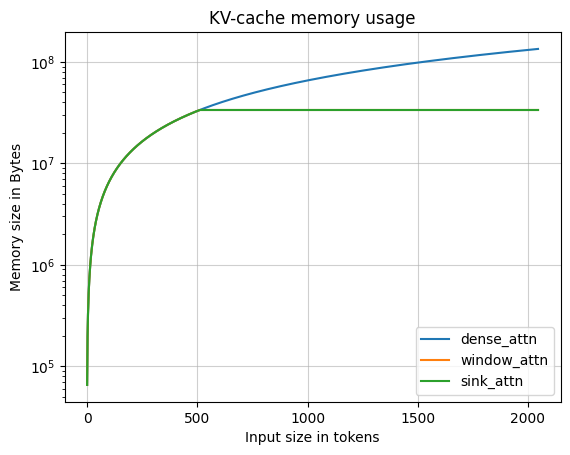

In [144]:
show_memory_usage(results)

In [145]:
def show_generation_times(results):
    for run in results["runs"]:
        generation_times = run["results"]["generation_times"]
        plt.plot(
            range(len(generation_times)),
            generation_times,
            linewidth=0.5,
            label=run["attn_impl"],
        )
    # plt.yscale("log")
    plt.title("Generation times")
    plt.xlabel("Input size in tokens")
    plt.ylabel("Time in seconds")

    plt.legend()
    plt.grid(alpha=0.6, zorder=1)

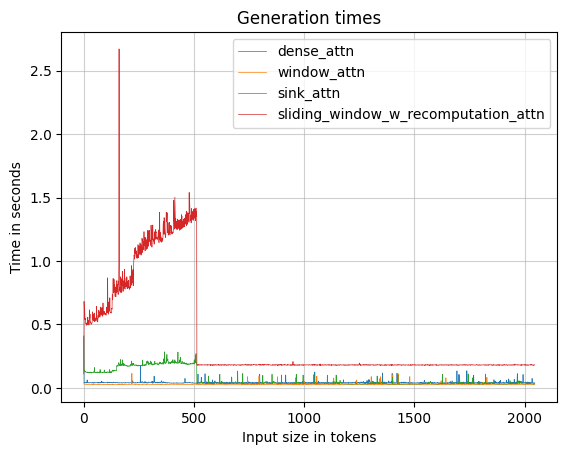

In [146]:
show_generation_times(results)

In [149]:
def show_nlls(results, kv_size_line: int = 0, context_length_line: int = 0):
    assert len(results["runs"]) > 0
    n_rows = len(results["runs"]) + 1

    fig, ax = plt.subplots(n_rows, 1, figsize=(14, 16))

    if kv_size_line > 0:
        for ax_id in range(n_rows):
            ax[ax_id].axvline(
                x=kv_size_line,
                color="green",
                linestyle="--",
                alpha=1,
                label="KV Cache Size",
            )
    if context_length_line > 0:
        for ax_id in range(n_rows):
            ax[ax_id].axvline(
                x=context_length_line,
                color="red",
                linestyle="--",
                alpha=1,
                label="Context Length",
            )

    colors = []
    for run in results["runs"]:
        nlls = run["results"]["nlls"]

        a = ax[0].plot(
            range(len(nlls)),
            [torch.Tensor(nlls[: i + 1]).mean() for i in range(len(nlls))],
            label=run["attn_impl"],
        )
        colors.append(a[0].get_color())

    for idx, run in enumerate(results["runs"]):
        nlls = run["results"]["nlls"]
        ax[idx + 1].plot(
            range(len(nlls)),
            [(nlls[i]) for i in range(len(nlls))],
            "o",
            color=colors[idx],
            # linewidth=0.1,
            markersize=1,
            label=run["attn_impl"],
        )

    ax[0].set_ylabel("Log PPL")
    for ax_id in range(n_rows):
        if ax_id > 0:
            ax[ax_id].set_ylabel("NLL (per token)")
            ax[ax_id].set_title(results["runs"][ax_id - 1]["attn_impl"])
        ax[ax_id].set_xlabel("Input size in tokens")
        ax[ax_id].grid(alpha=0.6, zorder=1)
        ax[ax_id].legend()
    fig.tight_layout()

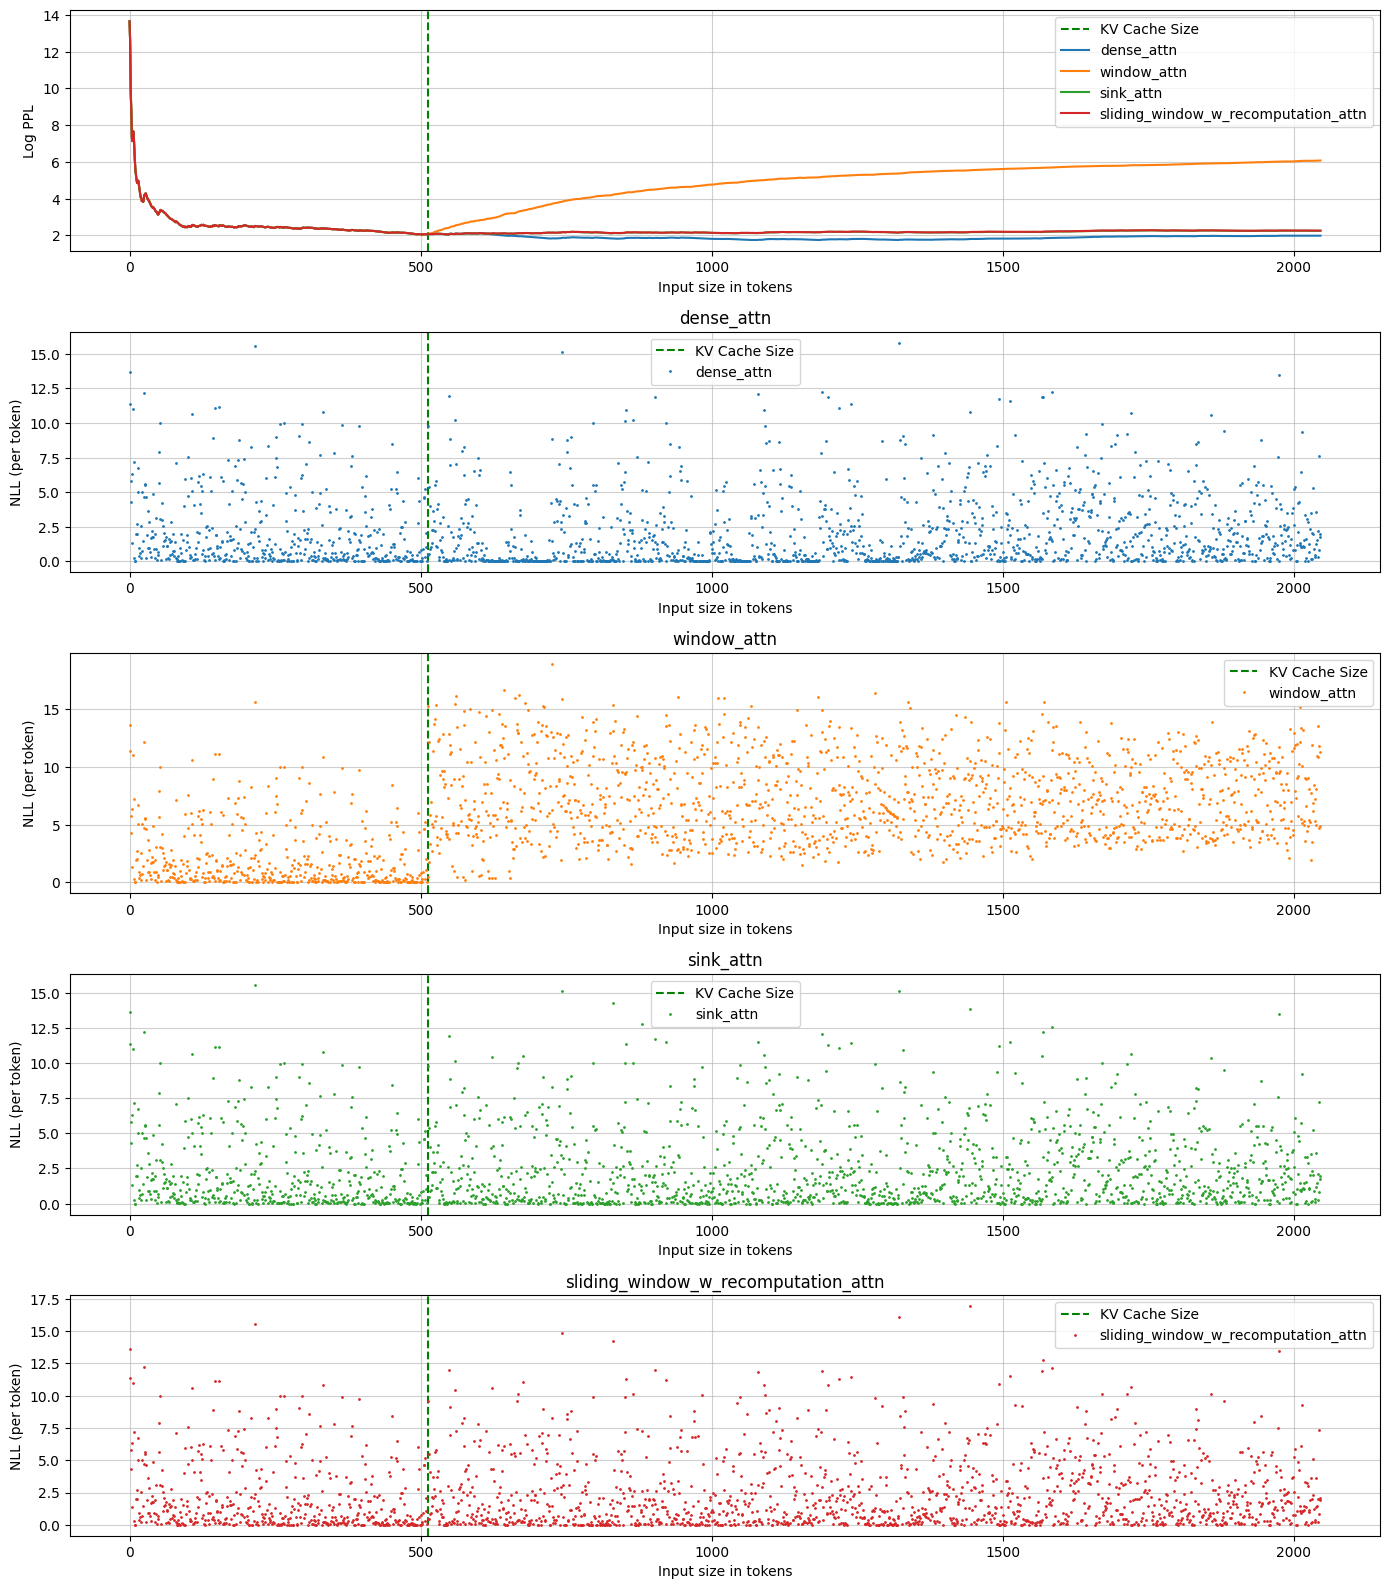

In [152]:
show_nlls(results, kv_size_line=512, context_length_line=0)

In [135]:
torch.mps.empty_cache()

## Attention visualisations

In [22]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast


model_path = "/Users/aszab/repos/models/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_path, output_attentions=True).to(device)

tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [23]:
model_path = "/Users/aszab/repos/models/Llama-3.2-1B"
model = LlamaForCausalLM.from_pretrained(model_path, output_attentions=True).to(device)

tokenizer = LlamaTokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'LlamaTokenizerFast'.


In [24]:
inputs = tokenizer(
    "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.",
    return_tensors="pt",
).to(device)

outputs = model(
    **inputs,
)

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [25]:
inputs = {"input_ids": encodings["input_ids"][:, :128].to(device)}
outputs = model(**inputs)

In [26]:
inputs["input_ids"]

tensor([[128000,    271,    284,   8563,    426,  11206,    466,    284,  77425,
           8563,    426,  11206,    466,    374,    459,   6498,   4632,   1174,
          12707,    323,  34596,  12360,    662,   1283,   1047,    264,   8810,
            571,     12,     31,  40500,   3560,    389,    279,  12707,   4101,
            578,   8766,    304,    220,   1049,     15,    662,   1115,    574,
           8272,    555,    264,  40500,   3560,    304,    279,   1514,   6385,
           2439,   5439,    555,  22021,  77023,   1174,    902,    574,  10887,
            304,    220,   1049,     16,    520,    279,  16591,   7301,  27315,
            662,   1283,   1047,    264,   8810,   3560,    304,    279,  12707,
           4101,  20819,   3842,   1611,    291,    304,    220,   1049,     17,
            662,    763,    220,   1049,     19,    426,  11206,    466,  27212,
            264,   3560,    439,    330,  29517,    330,    304,    279,   9417,
            330,  71166,    

In [27]:
outputs.attentions[0]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3101e-01, 6.6899e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.0273e-02, 9.0614e-01, 1.3589e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.4555e-01, 3.0943e-06, 1.2927e-06,  ..., 4.3425e-02,
           0.0000e+00, 0.0000e+00],
          [1.8142e-01, 5.0696e-06, 2.5758e-06,  ..., 1.5071e-01,
           6.4604e-02, 0.0000e+00],
          [1.7185e-01, 3.2761e-06, 1.4230e-06,  ..., 1.9595e-01,
           1.9431e-01, 6.5645e-02]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.8674e-01, 1.1326e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4930e-01, 4.4936e-01, 2.0134e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.6617e-01, 6.7747e-04, 7.1763e-05,  ..., 5.4679

In [28]:
torch.stack(outputs.attentions).cpu().detach().numpy().shape

(16, 1, 32, 128, 128)

In [29]:
def get_attn_map(
    attn: tuple[torch.Tensor], layer_num: int, head_num: int
) -> np.ndarray:
    """
    Retrieves the attention map for a specified layer and head from the model's attention outputs.

    Args:
        attn (tuple[torch.Tensor]): A tuple of attention tensors from the model's output.attentions.
        layer_num (int): The index of the layer from which to retrieve the attention map.
                         If -1, the attention maps across all layers are averaged.
        head_num (int): The index of the head from which to retrieve the attention map.
                        If -1, the attention maps across all heads are averaged.

    Returns:
        np.ndarray: The attention map for the specified layer and head.
    """
    attn = torch.stack(attn).cpu().detach().numpy()
    if layer_num == -1:
        attn = attn.mean(axis=0, keepdims=True)
        layer_num = 0

    if head_num == -1:
        attn = attn.mean(axis=2, keepdims=True)
        head_num = 0

    attn_map = attn[layer_num, 0, head_num, :, :]

    return attn_map

Text(0, 0.5, 'Propotion of attention given to the first token')

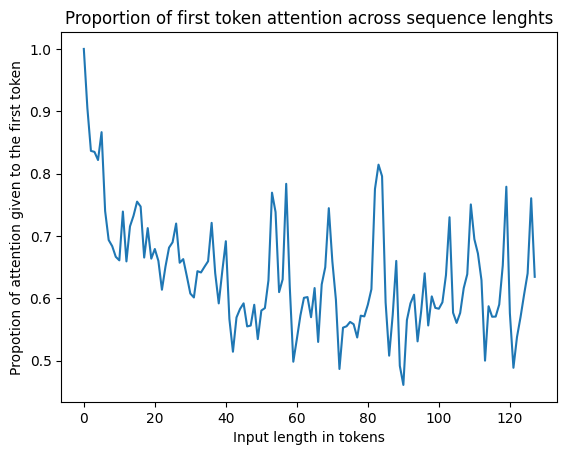

In [30]:
attn_map = get_attn_map(outputs.attentions, -1, -1)
plt.plot(range(attn_map.shape[1]), attn_map[:, 0])
plt.title("Proportion of first token attention across sequence lenghts")
plt.xlabel("Input length in tokens")
plt.ylabel("Propotion of attention given to the first token")

In [31]:
def show_attn(
    attn_map: np.ndarray, token_labels: list[str], log_scale: bool = False
) -> None:
    """
    Visualizes an attention map with token labels.

    Parameters:
        attn_map (np.ndarray): The attention map to visualize. It is expected to be a 2D array.
        token_labels (list[str]): A list of token labels corresponding to the attention map.
        log_scale (bool, optional): If True, applies a logarithmic scale to the attention map values. Defaults to False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    _, ax = plt.subplots(figsize=(8, 8))

    # mask for plotting the bad color for padding tokens (upper triangular part)
    attn_map = np.ma.masked_where(attn_map == 0, attn_map)

    cmap = plt.cm.coolwarm
    cmap.set_bad(color="grey")
    ax.matshow(fn(attn_map), cmap=cmap)

    ax.xaxis.set_label_position("bottom")  # Move x-axis label to the bottom
    ax.xaxis.tick_bottom()  # Ensure ticks are on the bottom
    _ = ax.set_xticks(
        range(len(inputs["input_ids"][0])),
        token_labels,
        fontsize=9,
        rotation=90,
    )
    _ = ax.set_yticks(
        range(len(inputs["input_ids"][0])),
        token_labels,
        fontsize=9,
    )
    ax.set_ylabel("Query token", fontsize=12)
    ax.set_xlabel("Key token", fontsize=12)

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_85100/1193795847.py:24: RuntimeWarning: divide by zero encountered in log
  ax.matshow(fn(attn_map), cmap=cmap)


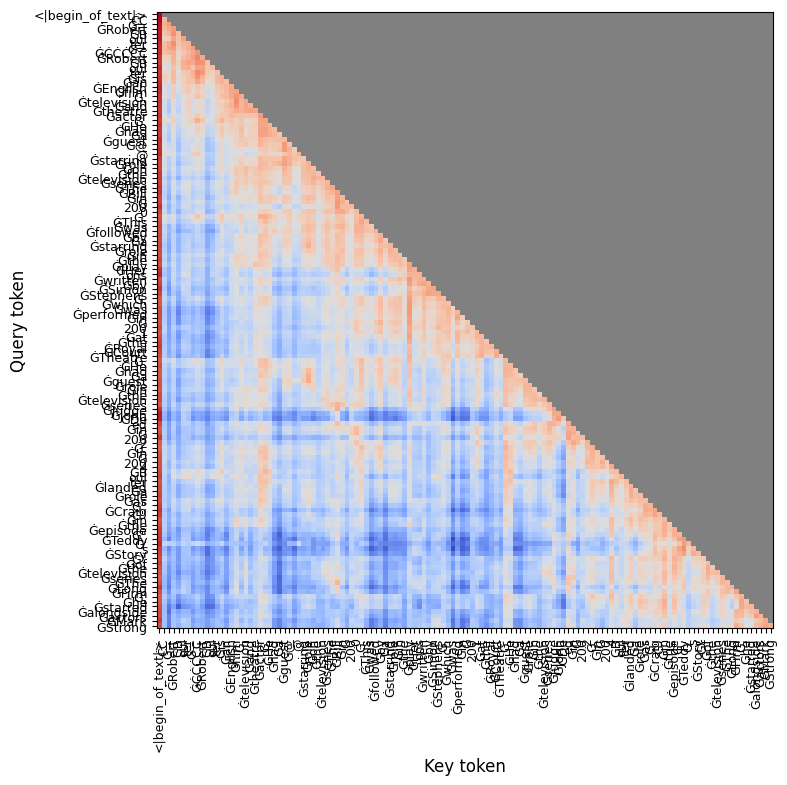

In [32]:
show_attn(
    get_attn_map(outputs.attentions, 7, -1),
    tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().detach().numpy()[0]),
    True,
)

In [33]:
def show_attn_layers(attn_map_lst: list[np.ndarray], log_scale: bool = False) -> None:
    """
    Visualizes attention maps for each layer in a grid layout.

    Parameters:
        attn_map_lst (list[np.ndarray]): A list of attention maps, where each attention map is a 2D numpy array.
        log_scale (bool): If True, applies a logarithmic scale to the attention maps for visualization. Default is False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    n_cols = 4
    n_rows = len(attn_map_lst) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 10))

    for i, attn_map in enumerate(attn_map_lst):
        # mask for plotting the bad color for padding tokens (upper triangular part)
        attn_map = np.ma.masked_where(attn_map == 0, attn_map)

        cmap = plt.cm.coolwarm
        cmap.set_bad(color="grey")
        axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)

        axs[i // n_cols][i % n_cols].xaxis.set_label_position(
            "bottom"
        )  # Move x-axis label to the bottom
        axs[i // n_cols][
            i % n_cols
        ].xaxis.tick_bottom()  # Ensure ticks are on the bottom

        axs[i // n_cols][i % n_cols].set_title(f"Layer {i}")
        axs[i // n_cols][i % n_cols].set_ylabel("Query token", fontsize=10)
        axs[i // n_cols][i % n_cols].set_xlabel("Key token", fontsize=10)
        fig.tight_layout()

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_85100/2761506107.py:24: RuntimeWarning: divide by zero encountered in log
  axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)


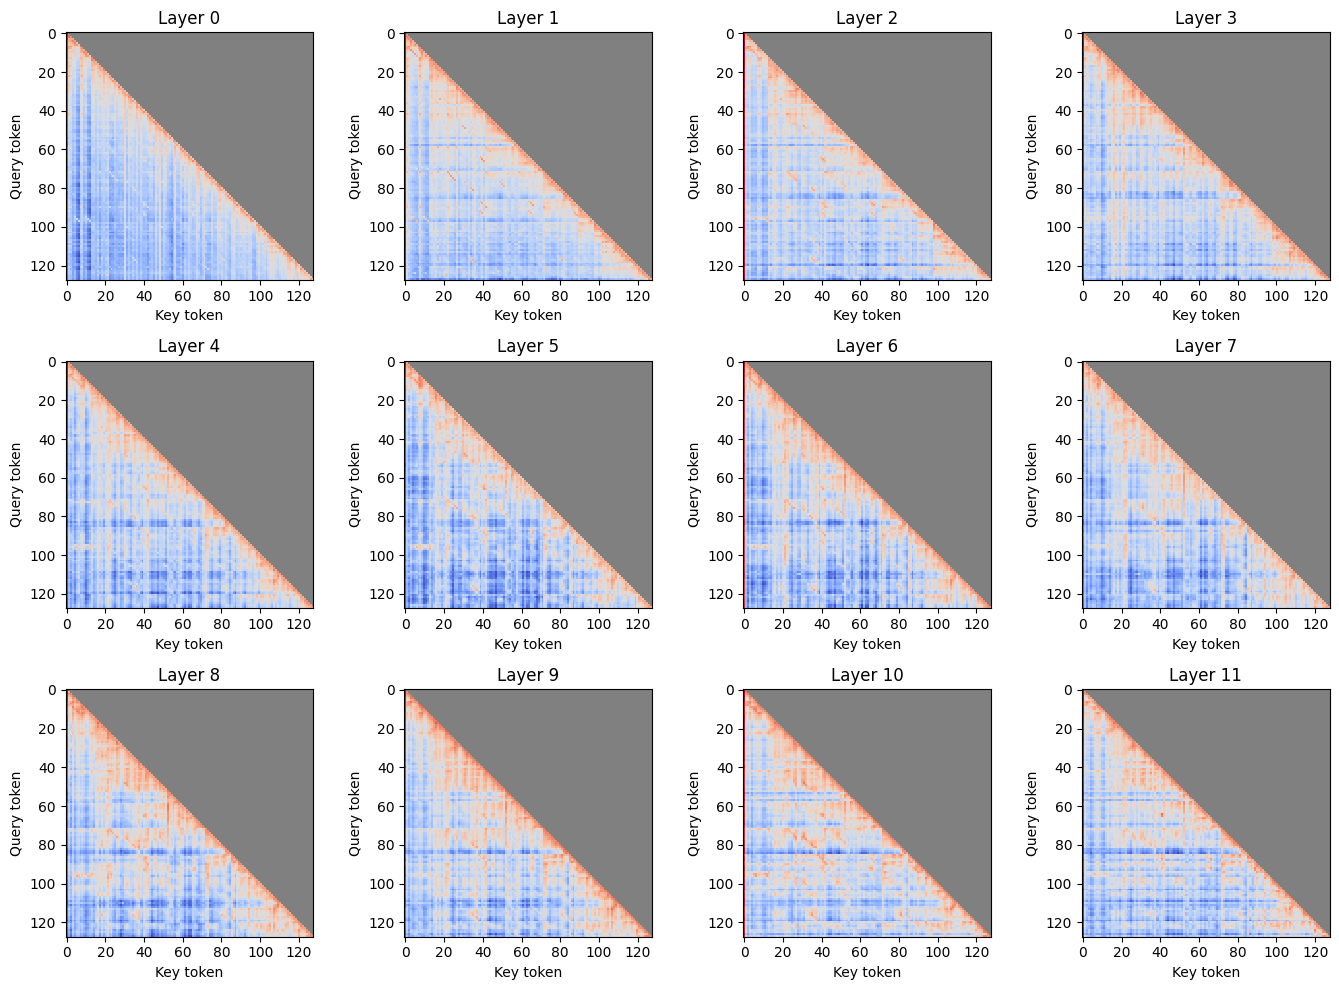

In [34]:
show_attn_layers(
    [get_attn_map(outputs.attentions, i, -1) for i in range(12)], log_scale=True
)